# Step 1: Import Libraries and Load the CLIP Model

In [9]:
import torch
import os
import clip
from PIL import Image, UnidentifiedImageError
import requests
from io import BytesIO
import mysql.connector
import pandas as pd
import time
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from dotenv import load_dotenv

In [8]:
# Load the CLIP model
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)

# Step 2: Connect to TiDB

In [10]:
def reconnect():
    try:
        connection = mysql.connector.connect(
            host=os.getenv('MYSQL_HOST'),
            user=os.getenv('MYSQL_USER'),
            password=os.getenv('MYSQL_PASSWORD'),
            database=os.getenv('MYSQL_DATABASE'),
            port=int(os.getenv('MYSQL_PORT'))
        )
        if connection.is_connected():
            print("Successfully connected to TiDB")
            return connection
    except mysql.connector.Error as e:
        print(f"Error: {e}")
        return None

# Establish the initial connection
connection = reconnect()
cursor = connection.cursor(dictionary=True)

Successfully connected to TiDB


# Step 3: Retrieve Data from TiDB

In [11]:
# Query the existing data
query = """SELECT id, motorbike_image_path
FROM detected_motorbikes_and_plates
WHERE motorbike_image_embedding IS NULL"""
cursor.execute(query)
data = pd.DataFrame(cursor.fetchall())

# Display the retrieved data
print(data.head())

    id                               motorbike_image_path
0  220  https://tidb-fa-hackathon.s3.amazonaws.com/mot...
1  221  https://tidb-fa-hackathon.s3.amazonaws.com/mot...
2  222  https://tidb-fa-hackathon.s3.amazonaws.com/mot...
3  223  https://tidb-fa-hackathon.s3.amazonaws.com/mot...
4  224  https://tidb-fa-hackathon.s3.amazonaws.com/mot...


# Step 4: Generate Image Embeddings Using CLIP

In [ ]:
# Function to generate image embeddings using CLIP
def get_image_embedding(image_url):
    try:
        response = requests.get(image_url)
        img = Image.open(BytesIO(response.content))

        # Preprocess the image for the CLIP model
        img_preprocessed = preprocess(img).unsqueeze(0).to(device)

        # Generate embedding using the CLIP model
        with torch.no_grad():
            embedding = model.encode_image(img_preprocessed).cpu().numpy().flatten()

        return embedding
    except UnidentifiedImageError:
        print(f"Cannot identify image from URL: {image_url}")
        return None
    except Exception as e:
        print(f"Error processing image from URL: {image_url}, Error: {e}")
        return None

# Generate embeddings for all images, skipping those that cause errors
data['embedding'] = data['motorbike_image_path'].apply(get_image_embedding)

# Check the DataFrame to ensure embeddings are created
print(data[['id', 'embedding']].head())

# Step 5: Batch Processing and Storing Embeddings in TiDB

In [ ]:
# Define the batch size
batch_size = 10  # Adjust based on what your server can handle
num_rows = len(data)

def store_embeddings(row):
    try:
        update_query = """
        UPDATE detected_motorbikes_and_plates
        SET motorbike_image_embedding = %s
        WHERE id = %s
        """
        cursor.execute(update_query, (row['embedding'].tobytes(), row['id']))
        connection.commit()
    except mysql.connector.Error as e:
        print(f"Error during update: {e}")
        connection.rollback()  # Rollback in case of error

# Apply batch processing
for start in range(0, num_rows, batch_size):
    end = min(start + batch_size, num_rows)
    batch_data = data.iloc[start:end]

    # Apply the store_embeddings function to this batch
    batch_data.apply(store_embeddings, axis=1)

    print(f"Processed rows {start} to {end}")

    # Sleep to avoid overwhelming the server
    time.sleep(1)

    # Check if connection is still alive
    if not connection.is_connected():
        print("Reconnecting to TiDB...")
        connection = reconnect()
        cursor = connection.cursor(dictionary=True)

# Step 6: Perform Vector Search Based on User Input

## 6.1. Just Print out the result

Since TiDB doesn't support COSINE_SIMILARITY, fetch the embeddings and perform the similarity calculation in Python.

In [12]:
# Fetch all embeddings from the database
fetch_embeddings_query = "SELECT id, motorbike_image_embedding FROM detected_motorbikes_and_plates"
cursor.execute(fetch_embeddings_query)
results = cursor.fetchall()

# Convert the BLOB back to numpy arrays
embeddings = []
ids = []
for row in results:
    ids.append(row['id'])
    embeddings.append(np.frombuffer(row['motorbike_image_embedding'], dtype=np.float32))

# Convert the list to a numpy array
embeddings = np.array(embeddings)

# Example of performing a vector search based on a user prompt
def get_prompt_embedding(prompt):
    # Use the CLIP model to generate text embeddings
    text_preprocessed = clip.tokenize([prompt]).to(device)
    with torch.no_grad():
        text_embedding = model.encode_text(text_preprocessed).cpu().numpy().flatten()
    return text_embedding

# User prompt example
user_prompt = "white white motorcycle"
query_embedding = get_prompt_embedding(user_prompt)

# Calculate cosine similarity
similarity_scores = cosine_similarity([query_embedding], embeddings)[0]

# Pair each ID with its similarity score and sort by similarity
similarity_results = sorted(zip(ids, similarity_scores), key=lambda x: x[1], reverse=True)

# Display the top 4 results
top_results = similarity_results[:4]
for result in top_results:
    print(f"ID: {result[0]}, Similarity Score: {result[1]}")

ID: 530, Similarity Score: 0.30537766218185425
ID: 238, Similarity Score: 0.30417466163635254
ID: 1224, Similarity Score: 0.3022386133670807
ID: 274, Similarity Score: 0.30189448595046997


## 6.2. Perform Vector Search and Display Images

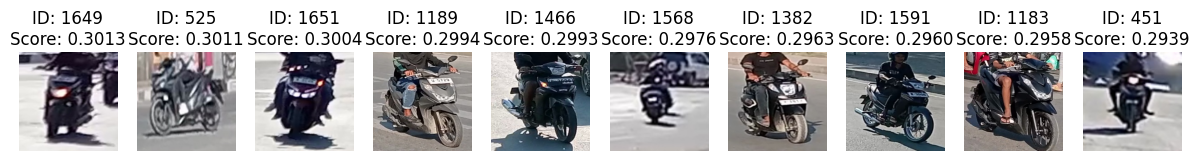

In [13]:
# Function to display images with similarity scores
def display_results_with_images(similarity_results, motorbike_image_paths):
    plt.figure(figsize=(15, 10))

    for i, (image_id, score) in enumerate(similarity_results):
        # Fetch the image URL
        image_url = motorbike_image_paths[image_id]

        # Load the image
        response = requests.get(image_url)
        img = Image.open(BytesIO(response.content))

        # Display the image with the similarity score
        plt.subplot(1, len(similarity_results), i + 1)
        plt.imshow(img)
        plt.title(f"ID: {image_id}\nScore: {score:.4f}")
        plt.axis('off')

    plt.show()

# Fetch all embeddings from the database
fetch_embeddings_query = "SELECT id, motorbike_image_path, motorbike_image_embedding FROM copy_detected_motorbikes_and_plates"
cursor.execute(fetch_embeddings_query)
results = cursor.fetchall()

# Convert the BLOB back to numpy arrays
embeddings = []
ids = []
motorbike_image_paths = {}
for row in results:
    ids.append(row['id'])
    embeddings.append(np.frombuffer(row['motorbike_image_embedding'], dtype=np.float32))
    motorbike_image_paths[row['id']] = row['motorbike_image_path']

# Convert the list to a numpy array
embeddings = np.array(embeddings)

# Example of performing a vector search based on a user prompt
def get_prompt_embedding(prompt):
    # Use the CLIP model to generate text embeddings
    text_preprocessed = clip.tokenize([prompt]).to(device)
    with torch.no_grad():
        text_embedding = model.encode_text(text_preprocessed).cpu().numpy().flatten()
    return text_embedding

# User prompt example
user_prompt = "black motorcycle"
query_embedding = get_prompt_embedding(user_prompt)

# Calculate cosine similarity
similarity_scores = cosine_similarity([query_embedding], embeddings)[0]

# Pair each ID with its similarity score and sort by similarity
similarity_results = sorted(zip(ids, similarity_scores), key=lambda x: x[1], reverse=True)

# Display the top 4 results with images
top_results = similarity_results[:10]
display_results_with_images(top_results, motorbike_image_paths)
